In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
states = pd.read_csv("us-states.csv")

counties = pd.read_csv("us-counties.csv")

## Prep County Data

In [3]:
counties["date"] = pd.to_datetime(counties.date, format = "%Y-%m-%d")

counties = counties.sort_values(by = ["county", "date" ]).reset_index(drop = True)

counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [4]:
unknown_indices = counties[counties.county == "Unknown"].index ## drop state level observations

counties = counties.drop(unknown_indices, axis = 0).reset_index(drop = True)

counties[counties.fips.isnull()].county.unique()

array(['Kansas City', 'New York City'], dtype=object)

In [5]:
kc_indices = counties[counties.county == "Kansas City"].index

ny_indices = counties[counties.county == "New York City"].index

for i in kc_indices:
    
    counties.at[i, "fips"] = -1 #assign non-null value so I can index through all counties by fips
                                #having an issue with shared county names
for j in ny_indices:
    
    counties.at[j, "fips"] = -2
    
#check my work
print(len(counties[counties.fips.isnull()]))

0


In [6]:
counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [7]:
county_frames = []

for cty in counties.fips.unique():
    
    county_df = counties[counties.fips == cty]
    
    county_df = county_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(county_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(county_df)):
            
            growth_rates.append((county_df.iloc[k]["cases"] / county_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(county_df)

    county_df = pd.concat([county_df, growth_rates], axis = 1)

    county_frames.append(county_df)

In [8]:
all_county = pd.concat(county_frames, axis = 0).reset_index(drop = True)

all_county.head()

,date,county,state,fips,cases,deaths,daily_growth_rate
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0,0.0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0,0.0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0,0.0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0,0.0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0,0.0


In [9]:
del county_frames

del counties

## Prepare State Data

In [10]:
states["date"] = pd.to_datetime(states.date, format = "%Y-%m-%d")

states = states.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [11]:
state_frames = []

for st in states.fips.unique():
    
    state_df = states[states.fips == st]
    
    state_df = state_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(state_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(state_df)):
            
            growth_rates.append((state_df.iloc[k]["cases"] / state_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(state_df)

    state_df = pd.concat([state_df, growth_rates], axis = 1)

    state_frames.append(state_df)
    
all_state = pd.concat(state_frames, axis = 0).reset_index(drop = True)

all_state.head()

,date,state,fips,cases,deaths,daily_growth_rate
0,2020-03-13,Alabama,1,6,0,0.000000
1,2020-03-14,Alabama,1,12,0,1.000000
2,2020-03-15,Alabama,1,23,0,0.916667
3,2020-03-16,Alabama,1,29,0,0.260870
4,2020-03-17,Alabama,1,39,0,0.344828


In [12]:
from IPython.display import display, HTML

In [13]:
def get_hot_counties(state: str, n_most = 10, all_county = all_county):
    
    state_df = all_county[all_county.state == state].reset_index(drop = True)
    
    hotspots = state_df[state_df.date == state_df.date.max()].sort_values(by = ["cases"], 
                                                                  ascending = False).county.values[:n_most]
    county_dfs = {}
    
    hot_counties = []
    
    for cty in hotspots:
        
        cty_df = state_df[state_df.county == cty].reset_index(drop = True)
        
        county_dfs[cty] = cty_df
        
        d = {}
        
        d["county"] = cty
        
        d["first_case"] = cty_df.date.min()
        
        d["total_cases"] = cty_df.iloc[-1]["cases"]
        
        d["previous_day_growth_rate"] = "{}%".format(
            round(cty_df.iloc[-1]["daily_growth_rate"] * 100, 2))
        
        if len(cty_df) >= 3:
            
            d["3day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-4:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["3day_avg_growth_rate"] = "Not Available"
            
        if len(cty_df) >= 7:
            
            d["7day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-8:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["7day_avg_growth_rate"] = "Not Available"
            
        hot_counties.append(d)
        
    summary_df = pd.DataFrame(hot_counties)
    
    print("The {} most effected counties in {}:".format(n_most, state))
    
    display(summary_df)
    
    return(county_dfs)
            
def analyze_state(state: str or int or float, all_county = all_county, all_state = all_state):
    
    if type(state) == str:
        
        state = state.capitalize()
        
        state_df = all_state[all_state.state == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            state_df = all_state[all_state.state == state.reset_index(drop = True)]
            
            if len(state_df) == 0:
                
                raise NameError("Please ensure state name is spelled correctly")
                
    elif type(state) == int or type(state) == float:
        
        state_df = all_state[all_state.fips == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            raise NameError("Please ensure correct FIPS entered")
            
    else:
        
        raise ValueError("Incorrect value passed to state. Please enter state name or state FIPS code")
        
    state_name = state_df.iloc[0]["state"]
    
    if len(state_df) == 1:
        
        return("{} recorded its first case of COVID-19 on {}, with {} total cases".format(
        state_name, state_df.iloc[-1]["date"], state_df.iloc[-1]["cases"]))
    
    else:
        
        print("{} reported its first cases of COVID-19 on {}, and has {} cases as of {}\n".format(
        state_name, state_df.date.min(), state_df.iloc[-1]["cases"], 
        state_df.date.max()))
        
        print("The previous daily growth rate was {}%\n".format(
            round(state_df.iloc[-1]["daily_growth_rate"] * 100, 2) ))
        
        if len(state_df) >= 3:
            
            _3day = state_df.iloc[-1:-4:-1].daily_growth_rate.mean()
            
            print("The 3 day average growth rate was {}%\n".format(
            round(_3day * 100, 2)))
            
        if len(state_df) >= 7:
            
            _7day = state_df.iloc[-1:-8:-1].daily_growth_rate.mean()
            
            print("The 7 day average growth rate was {}%\n".format(
            round(_7day * 100, 2)))
            
        c = get_hot_counties(state_name)
            
        fig, ax = plt.subplots(4, figsize = (15, 25))
        
        ax[0].scatter(state_df.date, state_df.cases, c = "k")
        
        ax[0].plot(state_df.date, state_df.cases)
        
        ax[0].set_title("Total Cases - {}".format(state_name), weight = "bold")
        
        ax[0].set_ylabel("Total Number of Cases", weight = "bold")
        
        ax[0].set_xlabel("Date", weight = "bold")
        
        ax[1].scatter(state_df.date, state_df.daily_growth_rate * 100, c = "k")
        
        ax[1].plot(state_df.date, state_df.daily_growth_rate * 100)
        
        ax[1].set_title("Daily Growth Rate - {}".format(state_name), weight = "bold")
        
        ax[1].set_ylabel("Percentage Growth (Case Numbers) from Previous Day", weight = "bold")
        
        ax[1].set_xlabel("Date", weight = "bold")
        
        for cty in c:
            
            ax[2].plot(c[cty].date, c[cty].cases, label = cty)
            
            ax[2].text(c[cty].iloc[-1]["date"], c[cty].iloc[-1]["cases"], c[cty].iloc[-1]["cases"],
                        horizontalalignment='left', weight = "bold")
            
            ax[3].plot(c[cty].date, c[cty].daily_growth_rate * 100, label = cty)
        
        ax[2].legend(bbox_to_anchor=(0.00, 1), loc='upper left', borderaxespad=0)
        
        ax[2].set_title("Cases by County - {}".format(state_name), weight = "bold")
        
        ax[2].set_ylabel("Number of Cases", weight = "bold")
        
        ax[2].set_xlabel("Date", weight = "bold")
        
        ax[3].legend(bbox_to_anchor=(0.00, 1), loc = "upper left", borderaxespad=0)
        
        ax[3].set_title("Daily Growth Rate by County - {}".format(state_name), weight = "bold")
        
        ax[3].set_ylabel("Percentage Growth (Caase Numbers) from Previous Day", weight = "bold")
        
        ax[3].set_xlabel("Date", weight = "bold")

California reported its first cases of COVID-19 on 2020-01-25 00:00:00, and has 8582 cases as of 2020-03-31 00:00:00

The previous daily growth rate was 15.64%

The 3 day average growth rate was 15.56%

The 7 day average growth rate was 18.41%

The 10 most effected counties in California:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Los Angeles,2020-01-26,3011,21.71%,18.64%,24.63%
1,Santa Clara,2020-01-31,890,4.95%,15.18%,13.55%
2,San Diego,2020-02-10,734,21.72%,14.75%,17.3%
3,Orange,2020-01-25,502,8.19%,16.7%,19.35%
4,San Francisco,2020-02-02,400,6.95%,9.12%,15.04%
5,Riverside,2020-03-07,371,27.49%,27.38%,33.77%
6,Alameda,2020-03-01,334,9.87%,6.46%,12.33%
7,San Mateo,2020-03-02,309,0.0%,4.22%,10.07%
8,Sacramento,2020-02-21,224,0.0%,12.2%,15.96%
9,Contra Costa,2020-03-03,222,18.72%,9.91%,14.73%


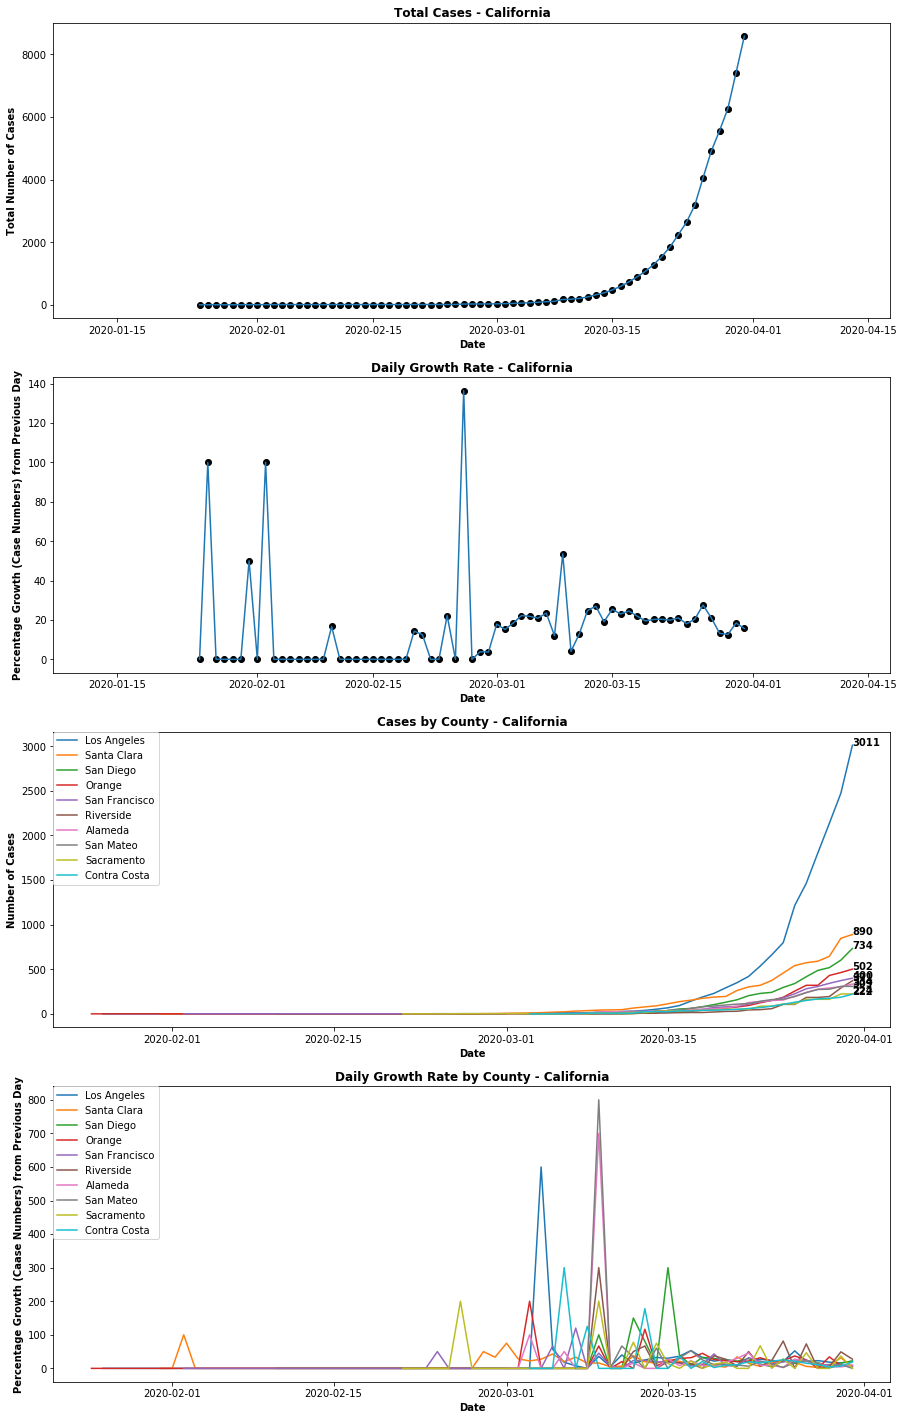

In [179]:
analyze_state("California")

Colorado reported its first cases of COVID-19 on 2020-03-05 00:00:00, and has 2990 cases as of 2020-03-31 00:00:00

The previous daily growth rate was 13.77%

The 3 day average growth rate was 13.21%

The 7 day average growth rate was 18.64%

The 10 most effected counties in Colorado:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Denver,2020-03-06,539,15.91%,13.69%,17.4%
1,Arapahoe,2020-03-09,350,13.64%,19.86%,26.31%
2,Jefferson,2020-03-05,304,20.16%,18.66%,22.86%
3,El Paso,2020-03-06,286,16.73%,15.84%,15.24%
4,Weld,2020-03-13,255,18.6%,16.62%,18.95%
5,Eagle,2020-03-06,227,6.57%,7.74%,13.35%
6,Adams,2020-03-12,185,20.92%,25.27%,31.99%
7,Douglas,2020-03-05,144,19.01%,16.17%,15.4%
8,Boulder,2020-03-14,107,7.0%,8.42%,12.06%
9,Larimer,2020-03-09,99,7.61%,7.82%,13.06%


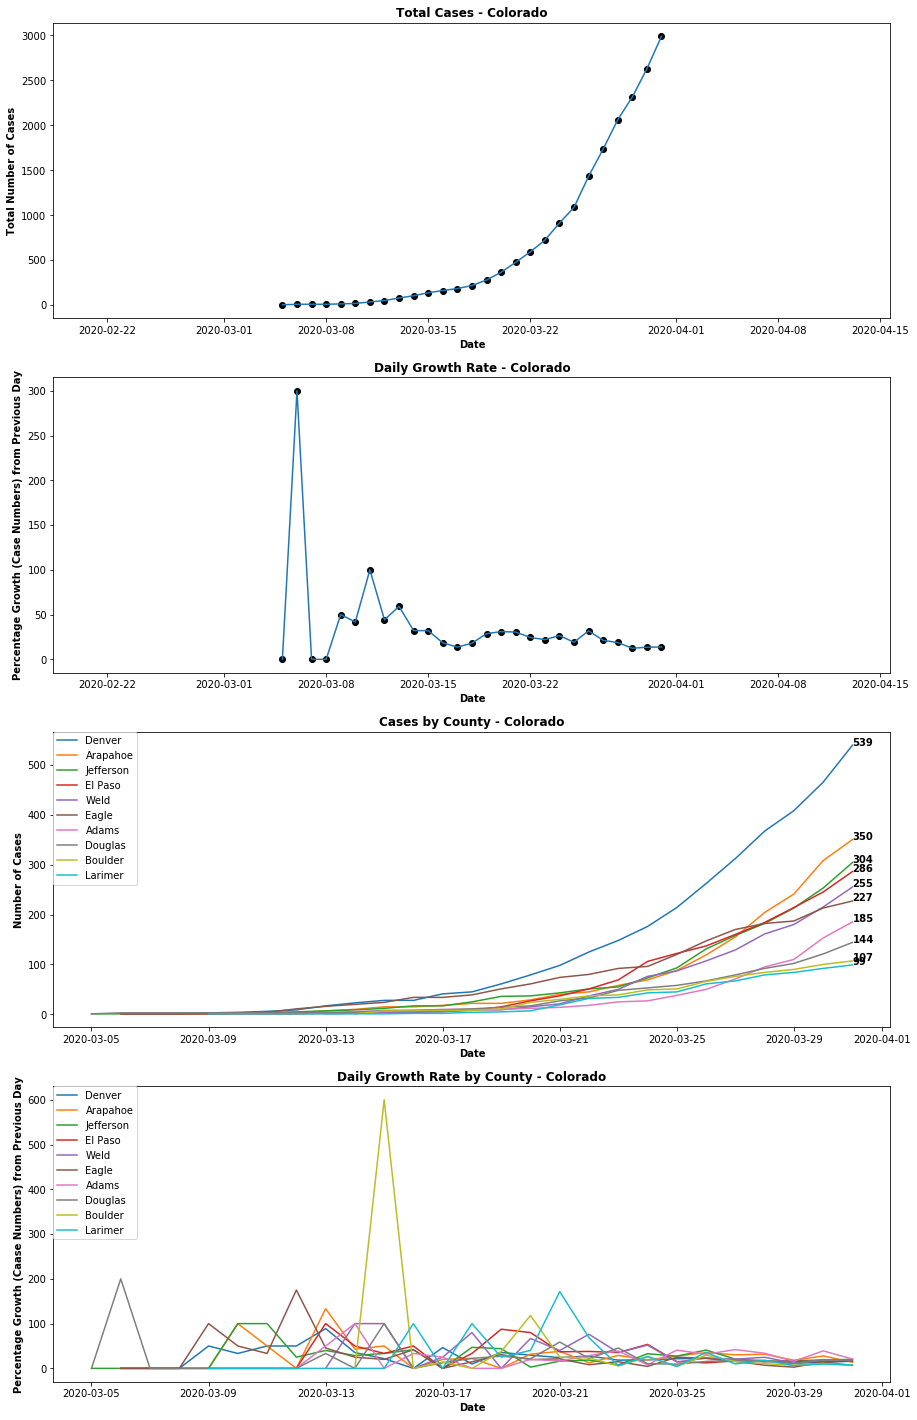

In [180]:
analyze_state("Colorado")

Illinois reported its first cases of COVID-19 on 2020-01-24 00:00:00, and has 5994 cases as of 2020-03-31 00:00:00

The previous daily growth rate was 18.22%

The 3 day average growth rate was 19.4%

The 7 day average growth rate was 21.73%

The 10 most effected counties in Illinois:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Cook,2020-01-24,4496,20.63%,20.22%,21.14%
1,Lake,2020-03-11,389,13.41%,13.79%,19.83%
2,DuPage,2020-03-14,356,11.25%,21.23%,20.09%
3,Will,2020-03-16,228,1.79%,13.84%,41.3%
4,Kane,2020-03-10,128,13.27%,12.46%,28.24%
5,McHenry,2020-03-10,63,21.15%,10.6%,25.82%
6,Kankakee,2020-03-18,47,23.68%,21.47%,48.08%
7,St. Clair,2020-03-14,43,19.44%,35.93%,32.7%
8,Champaign,2020-03-22,26,13.04%,20.86%,48.22%
9,McLean,2020-03-20,19,11.76%,24.4%,16.58%


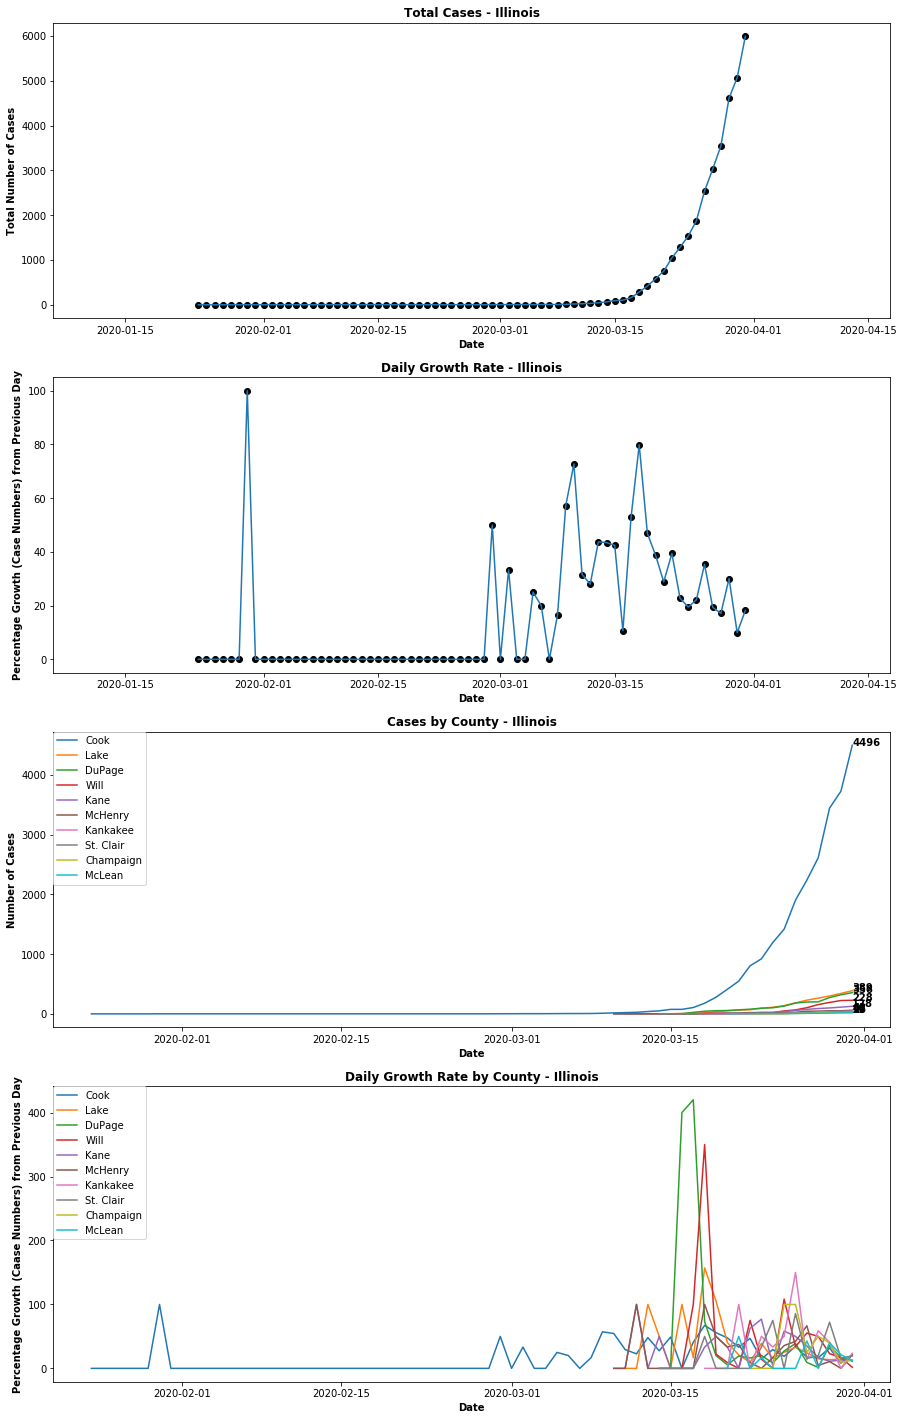

In [181]:
analyze_state("Illinois")

### GET N COUNTIES WITH MOST ACTIVE CASES

In [29]:
def get_most(county, n):
    
    most_recent = county[county.date == county.date.max()]
    
    hotspots = most_recent.sort_values(by = ["cases"], ascending = False).iloc[:n].fips
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    for cty in hotspots:
        
        county_dates = county[county.fips == cty].date
        
        county_cases = county[county.fips == cty].cases
        
        ax.scatter(county_dates, county_cases)

        ax.plot(county_dates, county_cases, label = county[county.fips == cty].county.max())
        
        ax.text(county_dates.iloc[-1], county_cases.iloc[-1], county_cases.iloc[-1],
                        horizontalalignment='left', weight = "bold")
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_title("{} Counties With Most Cases".format(n), weight = "bold")

    ax.set_xlabel("Date", weight = "bold")

    ax.set_ylabel("Number of Cases", weight = "bold");

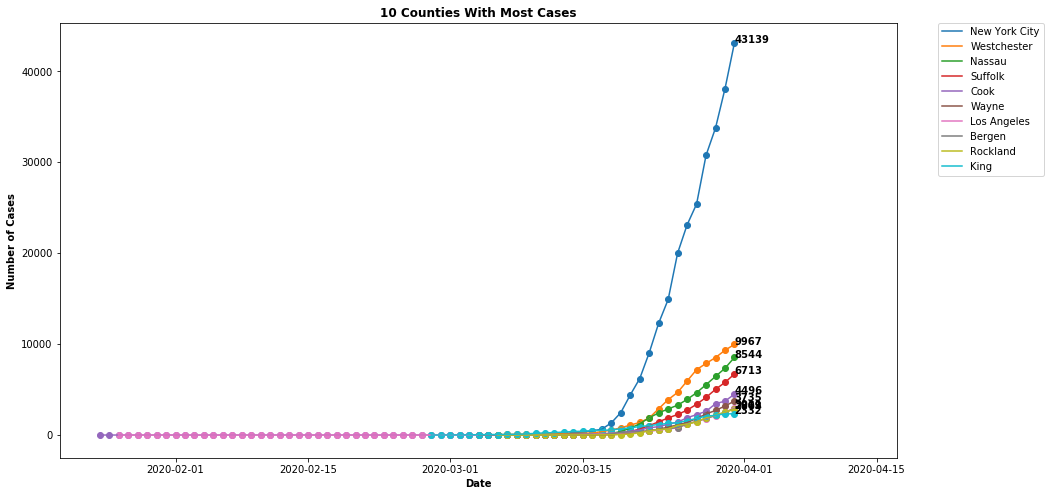

In [30]:
get_most(counties, 10)

### EXPLORING TESTING DATA- COURTESY OF COVID TRACKING PROJECT

In [14]:
testing = pd.read_csv("historical_testing.csv")

testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200402,AK,143.0,4879.0,NaN,NaN,9.0,NaN,NaN,NaN,...,9.0,5022,5022,5022,2,0.0,0.0,409.0,10.0,419.0
1,20200402,AL,1233.0,7503.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8736,8736,8736,1,6.0,0.0,806.0,156.0,962.0
2,20200402,AR,643.0,7880.0,NaN,66.0,NaN,NaN,NaN,23.0,...,NaN,8523,8523,8523,5,2.0,0.0,526.0,59.0,585.0
3,20200402,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200402,AZ,1598.0,21111.0,NaN,NaN,228.0,NaN,83.0,NaN,...,228.0,22709,22709,22709,4,3.0,79.0,1466.0,185.0,1651.0


In [17]:
testing["date"] = pd.to_datetime(testing.date, format = "%Y%m%d")

testing = testing.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [19]:
pd.set_option("max.columns", 50)

testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-03-06,AK,0.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b95ff00414e9a5542ba2aa08fdfda0b023c7c69c,2020-03-06T21:00:00Z,NaN,NaN,9,8,8,2,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,AK,0.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71953eb42494f6000afda41cda80b1b3dc836a83,2020-03-07T21:00:00Z,NaN,NaN,14,12,12,2,0.0,0.0,4.0,0.0,4.0
2,2020-03-08,AK,0.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844624448b0ee3ff7dd240e0d3f4258de1563064,2020-03-08T20:00:00Z,NaN,NaN,20,14,14,2,0.0,0.0,2.0,0.0,2.0
3,2020-03-09,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b5cbe627dd51a6e70136134185391030f93ffcb5,2020-03-09T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,9.0,0.0,9.0
4,2020-03-10,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6561feac0f53ef762911b4995038df195c62b2cb,2020-03-10T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,0.0,0.0,0.0


In [25]:
totals = pd.read_csv("state_test_hospitalization.csv")

totals = totals.drop(columns = ["notes", "hash"])

totals.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,lastUpdateEt,checkTimeEt,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked
0,AK,147,1.0,1.0,1.0,1.0,A,4.0,5353,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,4/02 16:00,4/03 09:02,3.0,13.0,5500,5500,5500,2,2020-04-02T20:00:00Z,2020-04-03T13:02:00Z
1,AL,1270,1.0,1.0,0.0,1.0,B,3.0,7503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4/03 00:00,4/03 09:02,32.0,NaN,8773,8773,8773,1,2020-04-03T04:00:00Z,2020-04-03T13:02:00Z
2,AR,683,1.0,1.0,1.0,1.0,A,4.0,8309,NaN,66.0,NaN,NaN,NaN,23.0,NaN,50.0,4/02 22:44,4/03 09:02,12.0,NaN,8992,8992,8992,5,2020-04-03T02:44:00Z,2020-04-03T13:02:00Z
3,AZ,1598,1.0,1.0,0.0,1.0,B,3.0,21111,NaN,NaN,228.0,NaN,83.0,NaN,NaN,NaN,4/02 00:00,4/03 10:31,32.0,228.0,22709,22709,22709,4,2020-04-02T04:00:00Z,2020-04-03T14:31:00Z
4,CA,9191,1.0,1.0,1.0,0.0,B,3.0,23809,59500.0,1922.0,NaN,816.0,NaN,NaN,NaN,NaN,4/01 00:00,4/03 09:17,203.0,NaN,92500,33000,33000,6,2020-04-01T04:00:00Z,2020-04-03T13:17:00Z


In [27]:
ca_testing = testing[testing.state == "CA"].reset_index(drop = True)

ca_testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-03-04,CA,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e89c69dcaf7f202257af579a58f86c340eee886a,2020-03-04T21:00:00Z,NaN,NaN,515,515,515,6,NaN,NaN,NaN,NaN,NaN
1,2020-03-05,CA,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ce0755ed64d8d97da631569ac60cacb5e301a000,2020-03-05T21:00:00Z,NaN,NaN,515,515,515,6,0.0,0.0,0.0,0.0,0.0
2,2020-03-06,CA,60.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ed5984edee3bf6ee9bc3b89bc15e52f3bdade592,2020-03-06T21:00:00Z,NaN,NaN,522,522,522,6,0.0,0.0,0.0,7.0,7.0
3,2020-03-07,CA,69.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311a213f5744c6b33147c107519218e8d9f55d23,2020-03-07T21:00:00Z,NaN,NaN,531,531,531,6,0.0,0.0,0.0,9.0,9.0
4,2020-03-08,CA,88.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39ba303e6c33d759f657dfaa835f2714a49ecc37,2020-03-08T20:00:00Z,NaN,NaN,550,550,550,6,0.0,0.0,0.0,19.0,19.0


### Positive Result Rate: The ratio of n_positive / n_negative

NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT ACCOUNTED FOR AS THE DATA IS NOT COMPLETE


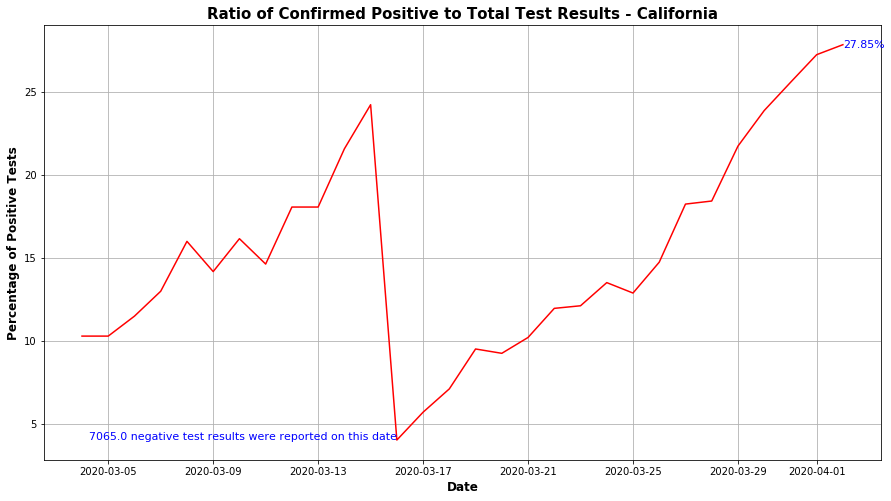

In [67]:
fig, ax = plt.subplots(figsize = (15, 8))

print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
 ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")

ax.plot(ca_testing.date, (ca_testing.positive / ca_testing.totalTestResults) * 100, c = "r", label = "Pos/Neg Ratio")

x_coord = ca_testing.iloc[12]["date"]

y_coord = (ca_testing.iloc[12]["positive"] / ca_testing.iloc[12]["totalTestResults"]) * 100

s = "{} negative test results were reported on this date".format(
    ca_testing.iloc[12]["negative"] - ca_testing.iloc[11]["negative"])

ax.text(x_coord, y_coord, s, horizontalalignment='right', c = "b", size = 11)

ax.text(ca_testing.date.max(), (ca_testing.iloc[-1]["positive"] / ca_testing.iloc[-1]["totalTestResults"]) * 100,
        "{}%".format(round((ca_testing.iloc[-1]["positive"] / ca_testing.iloc[-1]["totalTestResults"]) * 100,
                          2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

ax.grid(True)

ax.set_title("Ratio of Confirmed Positive to Total Test Results - California", 
             weight = "bold", size = 15)

ax.set_xlabel("Date", weight = "bold", size = 12)

ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
             size = 12);